In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pandas import read_csv
import math
from keras.models import Sequential
from keras.layers import Dense,LSTM, Bidirectional, Activation, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import time #helper libraries
from tensorflow.keras import regularizers

----
### Load Data

In [2]:
def load_transform_data():
    """
    Load energy and weather data sets for energy consumption over a 4 year period for a single household in Austin, Texas. 
    Perform transformations in order to get data into a format that we can more easily use for LSTM modeling.
    
    Notes
    -----
    Links to source of data:
    https://www.kaggle.com/srinuti/residential-power-usage-3years-data-timeseries?select=weather_2016_2020_daily.csv
    
    Parameters 
    ------
    None
    
    Returns
    -------
    df: pandas dataframe
        Contains both the energy and weather feature sets 
    """
    
    ###BEGIN SOLUTION
    
    # load energy data
    energy_data = "./Energy_Data/energy_usage_2016_to_2020.csv"
    df_energy = pd.read_csv(energy_data)
    
    # create datetime index
    df_energy.index = pd.to_datetime(df_energy.StartDate)
    
    # drop StartDate and day_of_week columns which are now redundent 
    drop_cols = ["StartDate", 
                 "day_of_week"]
    df_energy.drop(drop_cols, axis=1, inplace=True)
    
    # rename for better description of column
    df_energy.rename(columns={"notes":"day_type", "Value (kWh)":"kWh"}, inplace=True)
    
    # one-hot encode day types, i.e. vacation, weekday, or weekend 
    df_energy = pd.get_dummies(df_energy)

    # load weather data
    weather_data = "./Energy_Data/weather_2016_2020_daily.csv"
    df_weather = pd.read_csv(weather_data)
    
    # create datetime index
    df_weather.index = pd.to_datetime(df_weather.Date)
    
    # drop Date column which is now redundent 
    # day_type_COVID_lockdown is all zeros after all data transformations happen, so let's just drop the column
    drop_cols = ["Date"]
    df_weather.drop(drop_cols, axis=1, inplace=True)
    
    # let's convert our hourly energy data into daily mean so we can merge the datasets, ie. weather has daily granularity
    # resampling to the daily level is almost an arbitrary choice here: it simply makes for easier analysis
    # however, in practice, the level of granularity is a choice that is made based on needs of whatever problem you're working on
    # because the weather data as daily granularity, daily is the finest level we can use if we want to merge the datasets
    # though we are free to aggregate the data to the weekly, monthly, and even yearly level -- but we can do all that with df.resample() later 
    df_energy_day = df_energy.resample("D").mean()

    # merge energy and weather data
    df = df_energy_day.merge(df_weather,left_index=True, right_index=True)

    # dates don't perfectly overlap between energy and weather datasets which results in 52 daily null values -- drop them
    # this happend because some dates exist in one dataset but not the other
    nan_mask = df.isnull() == False
    df = df[nan_mask]
        
    # truncate series in order to drop missing values 
    df = df.loc["2016-06-01":"2020-01-01"]
    
    # day_type_COVID_lockdown is all zeros after all data transformations happen, so let's just drop the column 
    drop_col = ["day_type_COVID_lockdown"]
    df.drop(drop_col, axis=1, inplace=True)
    
    # return merged dataset 
    return df
    ###END SOLUTION
    

In [3]:
df = load_transform_data()

In [4]:
df.head()

,kWh,day_type_vacation,day_type_weekday,day_type_weekend,Day,Temp_max,Temp_avg,Temp_min,Dew_max,Dew_avg,...,Hum_avg,Hum_min,Wind_max,Wind_avg,Wind_min,Press_max,Press_avg,Press_min,Precipit,day_of_week
2016-06-06,1.221792,0.0,1.0,0.0,6,87,76.6,70,73,70.8,...,84.0,53,8,4.7,0,29.7,29.7,29.6,0.44,0
2016-06-07,1.806708,0.0,1.0,0.0,6,95,87.0,82,79,74.4,...,67.6,44,15,9.9,6,29.9,29.9,29.8,0.00,1
2016-06-08,2.333042,0.0,1.0,0.0,6,97,87.6,78,76,72.8,...,64.1,36,16,5.8,0,29.9,29.8,29.8,0.00,2
2016-06-09,1.626667,0.0,1.0,0.0,6,92,83.2,75,76,73.8,...,75.0,48,16,7.0,0,30.0,30.0,29.9,0.02,3
2016-06-10,1.416375,0.0,1.0,0.0,6,89,80.2,74,75,73.2,...,80.7,55,16,8.1,0,29.8,29.8,29.8,0.00,4


----
### Explore data with some plots

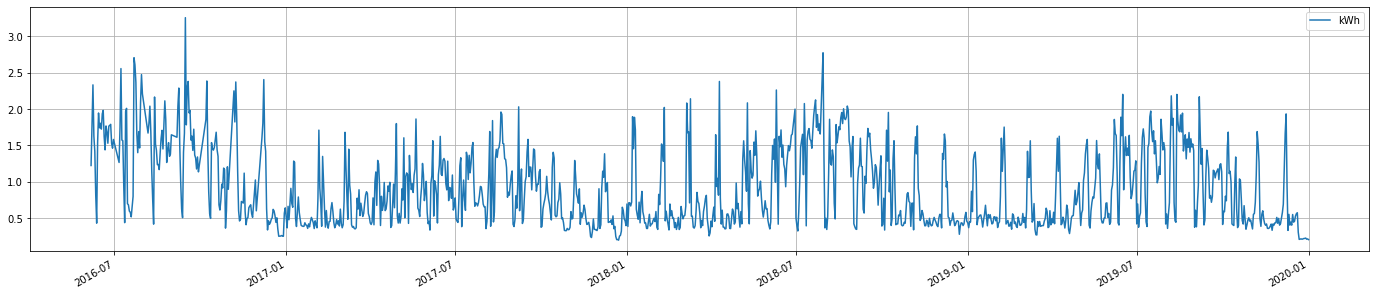

In [5]:
# seasonality: higher energy consumption during the summer months and lower in the winter months
# there doesn't seem to be any extreme outliers 
df.kWh.plot(figsize=(24,5), grid=True, legend=True);

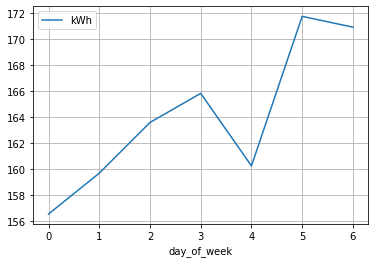

In [6]:
# index 0 is Monday
# index 6 is Sunday
df.groupby(["day_of_week"])[["kWh"]].sum().plot(grid=True);

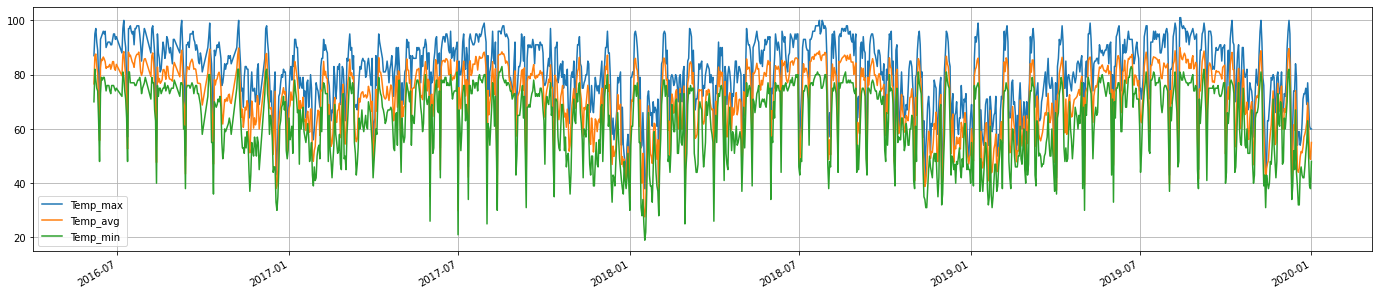

In [7]:
plot_cols = ["Temp_max", "Temp_avg", "Temp_min"]
df[plot_cols].plot(figsize=(24,5), grid=True, legend=True);

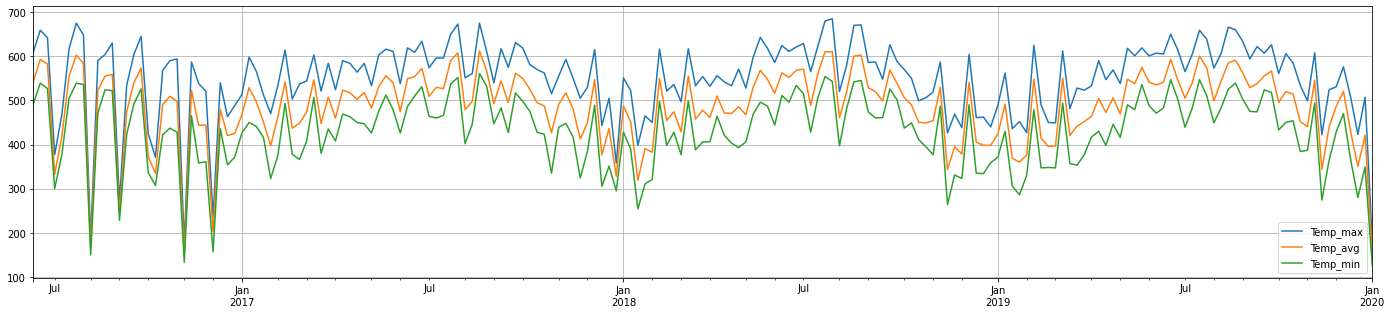

In [8]:
df[plot_cols].resample("W").sum().plot(figsize=(24,5), grid=True, legend=True);

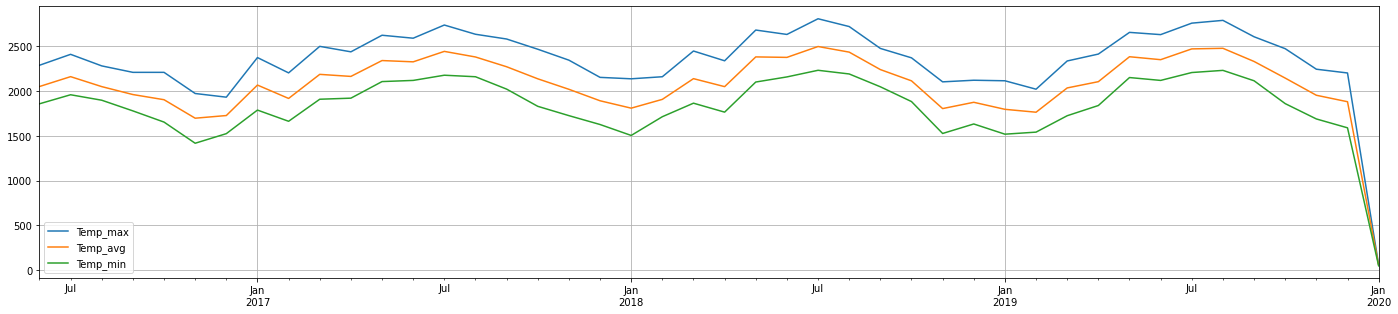

In [9]:
df[plot_cols].resample("M").sum().plot(figsize=(24,5), grid=True, legend=True);

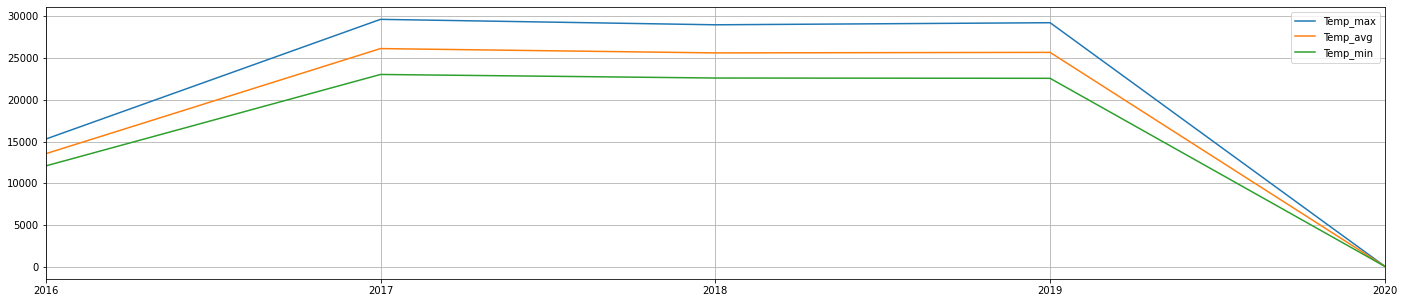

In [10]:
# be careful with this plot because 2016 and 2020 are partial years in our dataset 
df[plot_cols].resample("A").sum().plot(figsize=(24,5), grid=True, legend=True);

### Plot a Correlation Heatmap

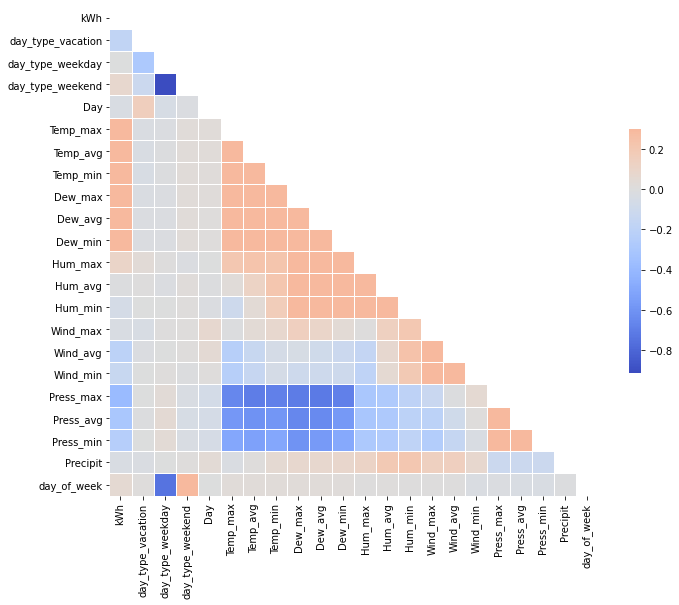

In [11]:
# plot the feature correlations 

# Compute the correlation matrix
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))


# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr,mask=mask, cmap="coolwarm", vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5});

### Feature Selection

In [12]:
def select_high_corr_features(df, corr_thresh = 0.10):
    """
    Feature selction algorithm based on correlation threshold 
    Features with a correlation to kWh less than corr_thresh will be dropped 
    """
    # create correlation threshold to filter out features with low correlation with the kWh column
    # create corr mask 
    corr_mask = corr.kWh.abs()>= corr_thresh
    # save surviving features to variable
    keep_feats = corr.kWh[corr_mask].index
    # mask columsn in dataframe
    return df[keep_feats]

In [13]:
df = select_high_corr_features(df, corr_thresh = 0.10)

In [14]:
df

,kWh,day_type_vacation,Temp_max,Temp_avg,Temp_min,Dew_max,Dew_avg,Dew_min,Hum_max,Wind_avg,Wind_min,Press_max,Press_avg,Press_min
2016-06-06,1.221792,0.0,87,76.6,70,73,70.8,68,100,4.7,0,29.7,29.7,29.6
2016-06-07,1.806708,0.0,95,87.0,82,79,74.4,69,89,9.9,6,29.9,29.9,29.8
2016-06-08,2.333042,0.0,97,87.6,78,76,72.8,65,90,5.8,0,29.9,29.8,29.8
2016-06-09,1.626667,0.0,92,83.2,75,76,73.8,70,97,7.0,0,30.0,30.0,29.9
2016-06-10,1.416375,0.0,89,80.2,74,75,73.2,69,97,8.1,0,29.8,29.8,29.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-28,0.216667,1.0,77,69.6,63,68,65.0,61,97,10.1,3,29.8,29.7,29.6
2019-12-29,0.221208,1.0,69,60.8,50,66,51.8,36,97,9.9,3,29.9,29.7,29.6
2019-12-30,0.206125,1.0,61,50.3,39,37,31.0,26,89,5.7,0,30.1,30.0,29.9
2019-12-31,0.210083,1.0,60,48.8,38,39,31.3,22,77,2.7,0,30.2,30.1,30.0


----
### Scale Data

In [15]:
def scale_data(df):
    """
    Scale time series features, save the scaler function for each feature in a look up dict for inverse scaling post model training. 
    
    Parameters
    ----------
    df: pandas dataframe
    
    Returns
    -------
    df: pandas datafarme 
        Contains scaled features
        
    scaler_dict: dict 
        look up for feature scaler objects 
        key: column name
        value: column scaler 
    """
    
    # use to save the column scaler functions
    scaler_dict = {} 
    
    # use to save the scaled column data
    scaled_data = {} 
    
    for col in df.columns:
        
        # instantiate the scaler class 
        scaler = MinMaxScaler(feature_range=(0, 1))
        
        # reshape to avoid shape errors
        feat = df[col].values.reshape(-1, 1)
        
        # scale data
        # DATA LEAKAGE! scaler should only be fitted on the training data
        # train test split should have occured prior to scaling 
        col_scaled = scaler.fit_transform(feat)
        
        # save scaled column data to column key
        scaled_data[col] = col_scaled.flatten()
        
        # save scaler function to column key 
        scaler_dict[col] = scaler
        
    # move scaled data from dict to dataframe
    df_scaled = pd.DataFrame.from_dict(scaled_data)
    
    return df_scaled, scaler_dict

In [16]:
# scale data 
df_scaled, scaler_dict = scale_data(df)

In [17]:
# dictionary with fitted (leakaged!) scalers for each column
scaler_dict.keys()

dict_keys(['kWh', 'day_type_vacation', 'Temp_max', 'Temp_avg', 'Temp_min', 'Dew_max', 'Dew_avg', 'Dew_min', 'Hum_max', 'Wind_avg', 'Wind_min', 'Press_max', 'Press_avg', 'Press_min'])

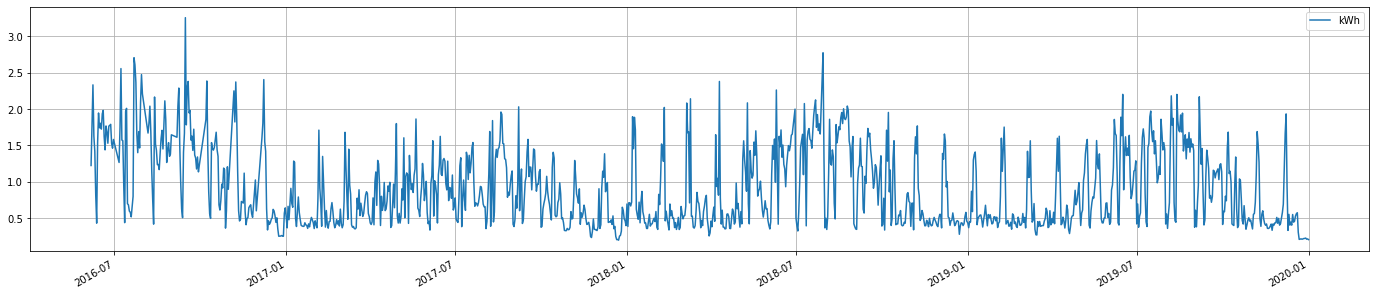

In [18]:
# plot non-scaled data
df.kWh.plot(figsize=(24,5), grid=True, legend=True);

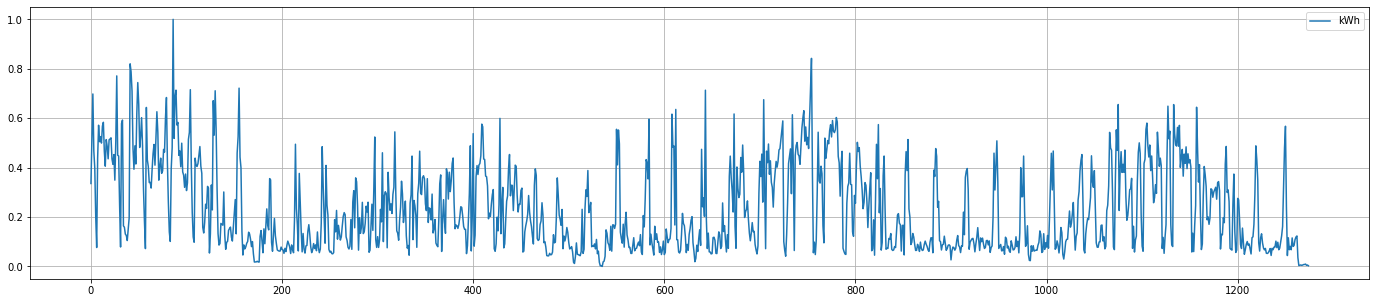

In [19]:
# plot scaled data
df_scaled.kWh.plot(figsize=(24,5), grid=True, legend=True);

----
### Create Samples

In [20]:
def create_dataset(data, look_back=1, look_ahead=1):
    """
    Takes a 2D array of sequential data and creates (X) input and (Y) output sequences for timeseries forecasting.
    
    Paramters
    ---------
    data: 2D numpy array
        contains sequential data with n rows and m columns
        
        If you provide more than a single input feature, make sure that the feature that is also used for the output
        is positioned in the 0 (zero) index column of the the array. Code below assumes this to be the case! 
        
        Example
        -------
        For the example data below, kWh column will be used as the output feature (i.e. what the model will be predicting).
        
                    kWh     Temp_avg
            0	0.335705	0.785256
            1	0.526399	0.951923
            2	0.697993	0.961538
            3	0.467702	0.891026
            4	0.399143	0.842949      
        
    look_back: int or float
        length of input sequence 
        
        I.E if look_behind = 1, then the input is a single value with index [t] (the present timestep)
            if look_behind = 2, then the input is a sequence of vlaues with indices [t - 1, t]
            if look_behind = n, then the input is a sequence of values with indices [t - n, t - (n - 1), ... , t - 1, t]
            
    look_ahead: int or float
        number of steps into the future that we want to forecast
        
        I.E. if look_ahead = 1, then we want to forecast the value 1 timestep from now,  t + 1
             if look_ahead = 2, then we want to forecast the value 2 timesteps from now, t + 2
             if look_ahead = b, then we want to forecast the value n timesteps from now, t + n
    """
    # use to store new sequence samples 
    X_data, Y_data = [], []
    
    # number of original samples in dataset
    n_samples = len(data)
    
    # avoid an index error in the for loop by capping the max index value 
    # since we are using look_back & look_ahead number of samples for input and output sequences, respectively
    truncate = look_back + look_ahead 
    
    # number of new samples to create
    # we must subtract truncate from the number of new samples because the size of the look_back & look_ahead windows 
    n_new_samples = n_samples - (truncate + 1)
    
    # if user provided data with more than a single input feature
    # then index for the feature in the 0 index and use that as the output feature
    if data.shape[1] > 1:
        y_data = data[:, 0]
        
    # if user provided a single feature dataset, leave data set as is 
    else:
        y_data = data
        
    # LOGIC FOR CREATING X AND Y 
    # we are going to create n_new_samples number of samples for our model 
    for i in range(n_new_samples):
        
        # create input sequence sample 
        x = data[i : i+look_back]
        
        # create output sequence sample 
        y = y_data[i+look_back : i + look_back + look_ahead ]
        y = y[-1] # y is actually a sequnce, so we need to take the last value as our output (i.e. we are predicting a single value, not multiple)
        
        # append new samples to lists
        X_data.append(x)
        Y_data.append(y)
        
    return np.array(X_data), np.array(Y_data)

![](https://3qeqpr26caki16dnhd19sv6by6v-wpengine.netdna-ssl.com/wp-content/uploads/2018/11/Sliding-Window-Approach-to-Modeling-Time-Series.png)

Let's create a small and simple dummy data set as input for `create_data` in order to see how the input and output data are structured. 

In [21]:
# create dummy array to test how function works
# note: the values here are completely arbitrary
# but using small, sequential integers helps us understanding the structuring of the sequences 
n = 11
dummy_data = np.arange(1, n)
dummy_data =dummy_data.reshape((dummy_data.shape[0], 1))
dummy_data


array([[ 1],
       [ 2],
       [ 3],
       [ 4],
       [ 5],
       [ 6],
       [ 7],
       [ 8],
       [ 9],
       [10]])

In [22]:
X_data, Y_data = create_dataset(dummy_data, 
                                look_back=1, 
                                look_ahead=1
                               )

In [23]:
X_data

array([[[1]],

       [[2]],

       [[3]],

       [[4]],

       [[5]],

       [[6]],

       [[7]]])

In [24]:
Y_data

array([[2],
       [3],
       [4],
       [5],
       [6],
       [7],
       [8]])

In [25]:
def create_train_test_split(df, look_back = 1, look_ahead = 1, train_size = 0.60):
    """
    Creates a train test split for sequential data used for time series forecasting. 
    """
    
    # calculate the number of training samples 
    n_samples = df.shape[0]
    train_size = int(n_samples * train_size)

    # samples between the zero and train_size indices are training samples 
    train = df.iloc[:train_size].values
    
    # samples between the train_size and the nth index are test samples 
    test = df.iloc[train_size:].values

    # create input and output splits 
    X_train, Y_train = create_dataset(train, look_back=look_back, look_ahead=look_ahead)
    X_test, Y_test = create_dataset(test, look_back=look_back, look_ahead=look_ahead)
    
    return X_train, Y_train, X_test, Y_test

![](https://i.stack.imgur.com/fXZ6k.png )

In [46]:
# split data into X and Y train/test sets 
look_back = 7
look_ahead = 1

X_train, Y_train, X_test, Y_test = create_train_test_split(df, 
                                                            look_back = look_back, 
                                                            look_ahead = look_ahead, 
                                                            train_size = 0.60)

In [47]:
# (numer of samples, number of time steps, number of input features for model)
X_train.shape

(756, 7, 14)

In [48]:
X_train.shape, Y_train.shape

((756, 7, 14), (756,))

In [49]:
X_test.shape, Y_test.shape

((501, 7, 14), (501,))

----
### Create and train model

In [50]:
# this model architecture is arbitrary - you can experiment with different architectures to see how it affects the score (i.e. gridsearch)
n_feats = len(df.columns)
epochs = 20
batch_size = 32
dropout_prob = 0.2

# (number of timesteps, number of features)
input_shape = (look_back, n_feats)

#### Create and train model here

# create sequenital instance
model = Sequential()

# add bidirectional lstm 
model.add(Bidirectional(LSTM(250, 
                             input_shape=input_shape, 
                             activation="relu")))

# add dropout regularization 
model.add(Dropout(dropout_prob))

# add dense hidden layer 
model.add(Dense(50, activation="relu", kernel_regularizer=regularizers.L2(l2=0.001)))
    
# add dense output layer 
model.add(Dense(1,  activation="relu"))

# compile computational graph - under the hood ;)
model.compile(loss="mean_squared_error", optimizer="nadam", metrics=["mean_squared_error", "mean_absolute_error"])

In [51]:
history = model.fit(X_train, 
                    Y_train, 
                    epochs=epochs, 
                    batch_size=batch_size, 
                    verbose=1, 
                    validation_data=(X_test, Y_test))

Epoch 1/20
24/24 [==============================] - 3s 34ms/step - loss: 24.7059 - mean_squared_error: 24.6224 - mean_absolute_error: 2.4260 - val_loss: 1.0242 - val_mean_squared_error: 0.9590 - val_mean_absolute_error: 0.8431
Epoch 2/20
24/24 [==============================] - 1s 22ms/step - loss: 1.2259 - mean_squared_error: 1.1655 - mean_absolute_error: 0.9333 - val_loss: 1.0079 - val_mean_squared_error: 0.9590 - val_mean_absolute_error: 0.8431
Epoch 3/20
24/24 [==============================] - 1s 23ms/step - loss: 1.1719 - mean_squared_error: 1.1256 - mean_absolute_error: 0.9180 - val_loss: 0.9993 - val_mean_squared_error: 0.9590 - val_mean_absolute_error: 0.8431
Epoch 4/20
24/24 [==============================] - 1s 22ms/step - loss: 1.1029 - mean_squared_error: 1.0638 - mean_absolute_error: 0.8878 - val_loss: 0.9950 - val_mean_squared_error: 0.9590 - val_mean_absolute_error: 0.8431
Epoch 5/20
24/24 [==============================] - 1s 22ms/step - loss: 1.0993 - mean_squared_err

---
### Visualize model results

In [52]:
def plot_model_loss_metrics(history):
    """
    Use the model history callback to plot the train and test losses vs epochs as well as metrics vs. epochs 
    """
    
    # plot training and test loss scores
    # HARD CODING IS A NO-NO
    # better written code would have the flexibility to plot whatever metrics the user provides 
    test_loss = history.history["val_loss"]
    train_loss = history.history["loss"]
    
    test_mse = history.history["val_mean_squared_error"]
    train_mse = history.history["mean_squared_error"]
    
    test_mae = history.history["val_mean_absolute_error"]
    train_mae = history.history["mean_absolute_error"]
    
    n_epochs = len(test_loss) + 1
    epoches = np.arange(1,  n_epochs)
    y_ticks = np.arange(0, 1, 11)

    plt.figure(figsize=(20,5))
    plt.title("Loss vs. Number of Epochs")
    plt.plot(epoches, test_loss, label = "Test Loss")
    plt.plot(epoches, train_loss, label = "Train Loss")
    plt.xlim(1,20)
    plt.xticks(epoches)
    plt.grid()
    plt.legend()
    plt.show() 
    
    
    plt.figure(figsize=(20,5))
    plt.title("mean_squared_error vs. Number of Epochs")
    plt.plot(epoches, test_mse, label = "Test Loss")
    plt.plot(epoches, train_mse, label = "Train Loss")
    plt.xlim(1,20)
    plt.xticks(epoches)
    plt.grid()
    plt.legend()
    plt.show() 
    
    
    plt.figure(figsize=(20,5))
    plt.title("mean_absolute_error vs. Number of Epochs")
    plt.plot(epoches, test_mae, label = "Test Loss")
    plt.plot(epoches, train_mae, label = "Train Loss")
    plt.xlim(1,20)
    plt.xticks(epoches)
    plt.grid()
    plt.legend()
    plt.show() 

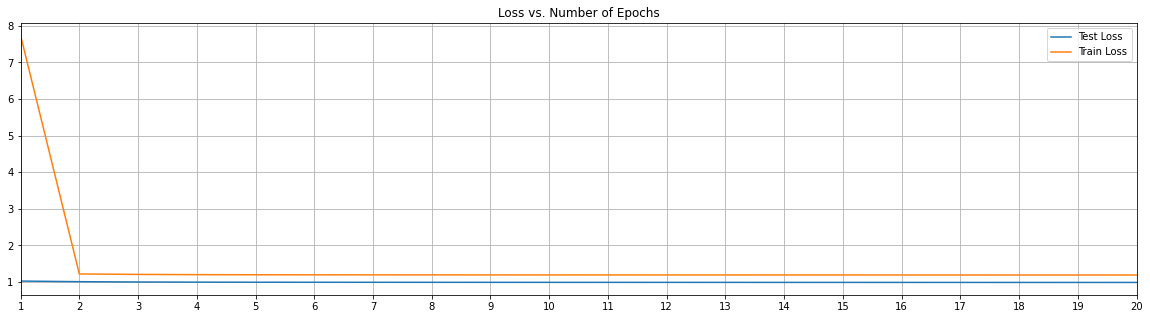

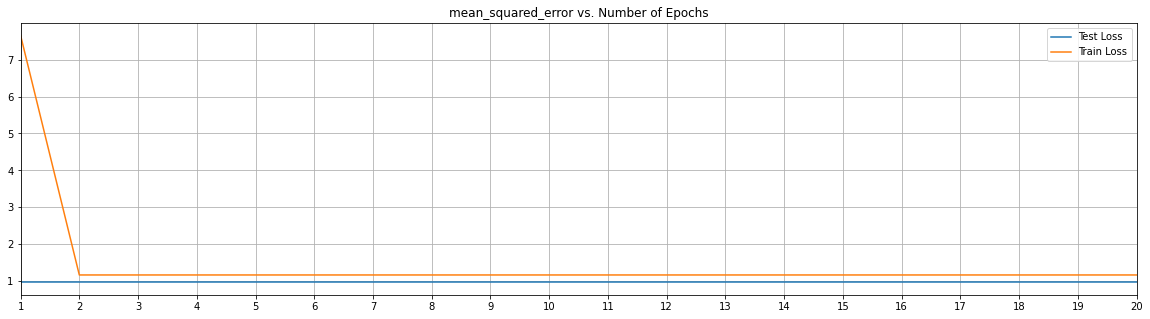

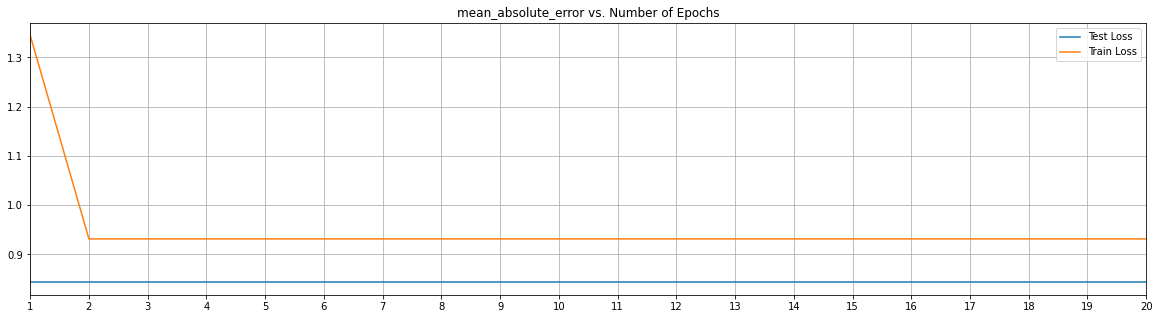

In [53]:
# plot model scores
plot_model_loss_metrics(history)

In [54]:
def predict(X_train, X_test):
    # make predictions on train and test inputs 
    y_train_predict = model.predict(X_train)
    y_test_predict = model.predict(X_test)
    
    return y_train_predict, y_test_predict

In [55]:
# get predictions 
y_train_predict, y_test_predict = predict(X_train, X_test)

In [56]:
# Y_test and Y_train can be passed through this function only once
# predictions can be passed in here multiple times 
def inverse_scaling(data, scaler_dict, output_feat_name):
    """
    Now that we have trained our model on scaled data (and made predictions on the scaled test data)
    we need to invert the scaling so we have have the data in it's original formate for interpretability. 
    """
    return scaler_dict[output_feat_name].inverse_transform(data)

In [57]:
# reshape Y_train and Y_test so number of rows appers first, i.e. (rows,cols)
Y_train = Y_train.reshape((Y_train.shape[0], 1))
Y_test = Y_test.reshape((Y_test.shape[0], 1))

# perform inverse scaling of the Y train and test sets
Y_train = inverse_scaling(Y_train, scaler_dict, "kWh")
Y_test = inverse_scaling(Y_test, scaler_dict, "kWh")

In [58]:
# perform inverse scaling of the model predictions 
y_train_predict = inverse_scaling(y_train_predict, scaler_dict, "kWh")
y_test_predict = inverse_scaling(y_test_predict, scaler_dict, "kWh")

----
### Plot Model Predictions

In [43]:
def plot_predictions(Y_train, y_train_predict, Y_test, y_test_predict):
    
    
    plt.figure(figsize=(20,5))
    plt.title("Training Set: True vs Predicted kWh")
    plt.grid()
    plt.plot(y_train_predict, label = "Predict", c="r")
    plt.plot(Y_train, label= "True", c="c")
    plt.xlim((0,300))
    plt.legend();
    
    plt.figure(figsize=(20,5))
    plt.title("Test Set: True vs Predicted kWh")
    plt.grid()
    plt.plot(y_test_predict, label = "Predict", c="r")
    plt.plot(Y_test, label= "True", c="c")
    plt.xlim((0,300))
    plt.legend();

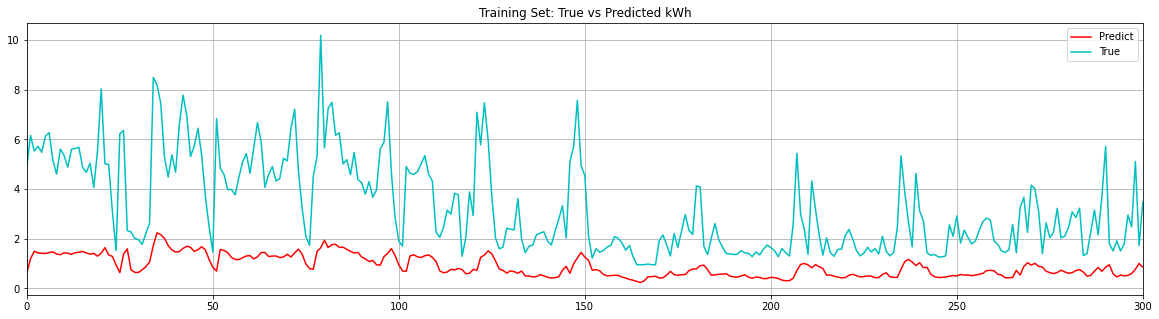

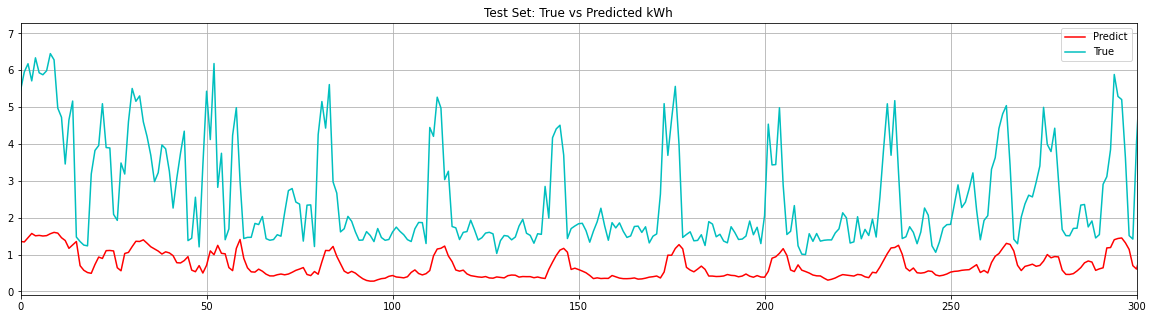

In [44]:
# plot model predictions 
plot_predictions(Y_train, y_train_predict, Y_test, y_test_predict)

-----
### Compare Model against a Baseline 

One commen baseline to use is to simply shift the kWh values up by `look_ahead` amount and compare that to the true values that occur an a date. In order words, assume that the kWh consumption tomorrow will be the same as the energy consumption to today. So then we can ask the question "can the model perform better than simply assuming that tomorrow will look like today?"

Of course since `look_ahead` can be any value (not just 1) then the navie guess becomes "assume that the kWh consumption X number of days from now be the same as today."

In [45]:
# use root mean squared error as metric for comparison 
train_score = math.sqrt(mean_squared_error(Y_train, y_train_predict))
print('Train Score: %.4f RMSE' % (train_score))

test_score = math.sqrt(mean_squared_error(Y_test, y_test_predict))
print('Test Score: %.4f RMSE' % (test_score))

navie_score = math.sqrt(mean_squared_error(true_kwh_daily, guess_that_tommorrow_is_like_today))
print('Naive baseline Score: %.4f RMSE' % (test_score))

Train Score: 2.6169 RMSE
Test Score: 2.3744 RMSE


NameError: name 'true_kwh_daily' is not defined